In [1]:
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pickle
from simtk import unit

###############################################
# either with or without regularization
base = '../optimization/with_regularization'
#base = '../optimization/without_regularization'
###############################################

#load files
results = pickle.load(open(f'{base}/full_results.pickle', 'rb'))
max_epochs = len(results['SAMPLmol2']['SAMPLmol2'])

with open(f'{base}/deviation_from_ani1x_dataset.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    dev = [row for row in csv_reader]
rmse = [float(i) for i in dev[0]]
mae = [float(i) for i in dev[1]]
# load  data about the molecules in training/validation/test set
all_names: dict = pickle.load(open("../optimization/training_validation_tests.pickle", "br"))

In [2]:
from neutromeratio.parameter_gradients import (
    get_experimental_values
)
from neutromeratio.analysis import bootstrap_rmse_r
from neutromeratio.constants import (
    kT
)

# order data
data_set_type = dict()
for name in results:
    data_set_type[name] = results[name][name][0][-1]
# get exp values (all in kcal/mol)
exp = {}
for name in all_names:
    value = get_experimental_values(name).item()
    value = (float(value) * kT).value_in_unit(unit.kilocalorie_per_mole)
    exp[name] = value

# load the results for each epoch on the training/validation/test set 
validation_results_bootstrapped = list()
training_results_bootstrapped = list()
test_results = list()
penalty_training_ = list()
penalty_validation_ = list()
penalty_testing_ = list()
# iterate through epochs
for i in range(0, max_epochs):
    validation_set_performance = []
    training_set_performance = []
    test_set_performance = []
    exp_corresponding_to_validation_set = []
    exp_corresponding_to_training_set = []
    exp_corresponding_to_test_set = []
    penalty_training = list()
    penalty_validation = list()
    penalty_testing = list()
    # for each name in epoch i extract the performance 
    for name in all_names:
        if data_set_type[name] == 'validating':
            r = results[name][name][i][0]
            validation_set_performance.append((float(r) * kT).value_in_unit(unit.kilocalorie_per_mole))
            exp_corresponding_to_validation_set.append(exp[name])
            p = results[name][name][i][1]
            penalty_validation.append((float(p) * kT).value_in_unit(unit.kilocalorie_per_mole))

        elif data_set_type[name] == 'training':
            r = results[name][name][i][0]
            training_set_performance.append((float(r) * kT).value_in_unit(unit.kilocalorie_per_mole))
            exp_corresponding_to_training_set.append(exp[name])
            p = results[name][name][i][1]
            penalty_training.append((float(p) * kT).value_in_unit(unit.kilocalorie_per_mole))

        else:
            r = results[name][name][i][0]
            test_set_performance.append((float(r) * kT).value_in_unit(unit.kilocalorie_per_mole))
            exp_corresponding_to_test_set.append(exp[name])
            p = results[name][name][i][1]
            penalty_testing.append((float(p) * kT).value_in_unit(unit.kilocalorie_per_mole))

    # calculate the deviation for the snapshots with theta and theta*
    penalty_training_.append(np.sqrt(np.average(np.array(penalty_training)**2)))
    penalty_validation_.append(np.sqrt(np.average(np.array(penalty_validation)**2)))
    penalty_testing_.append(np.sqrt(np.average(np.array(penalty_testing)**2)))
    test_results.append(test_set_performance)

    training_results_bootstrapped.append(bootstrap_rmse_r(np.array(exp_corresponding_to_training_set), np.array(training_set_performance), nsamples=500))        
    validation_results_bootstrapped.append(bootstrap_rmse_r(np.array(exp_corresponding_to_validation_set), np.array(validation_set_performance), nsamples=500))


[__init__.py:17 - <module>()] Enabling RDKit 2021.03.3 jupyter extensions
[utils.py:157 - _init_num_threads()] NumExpr defaulting to 8 threads.


/home/mwieder/anaconda3/envs/ani/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mwieder/anaconda3/envs/ani/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/mwieder/anaconda3/envs/ani/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/h

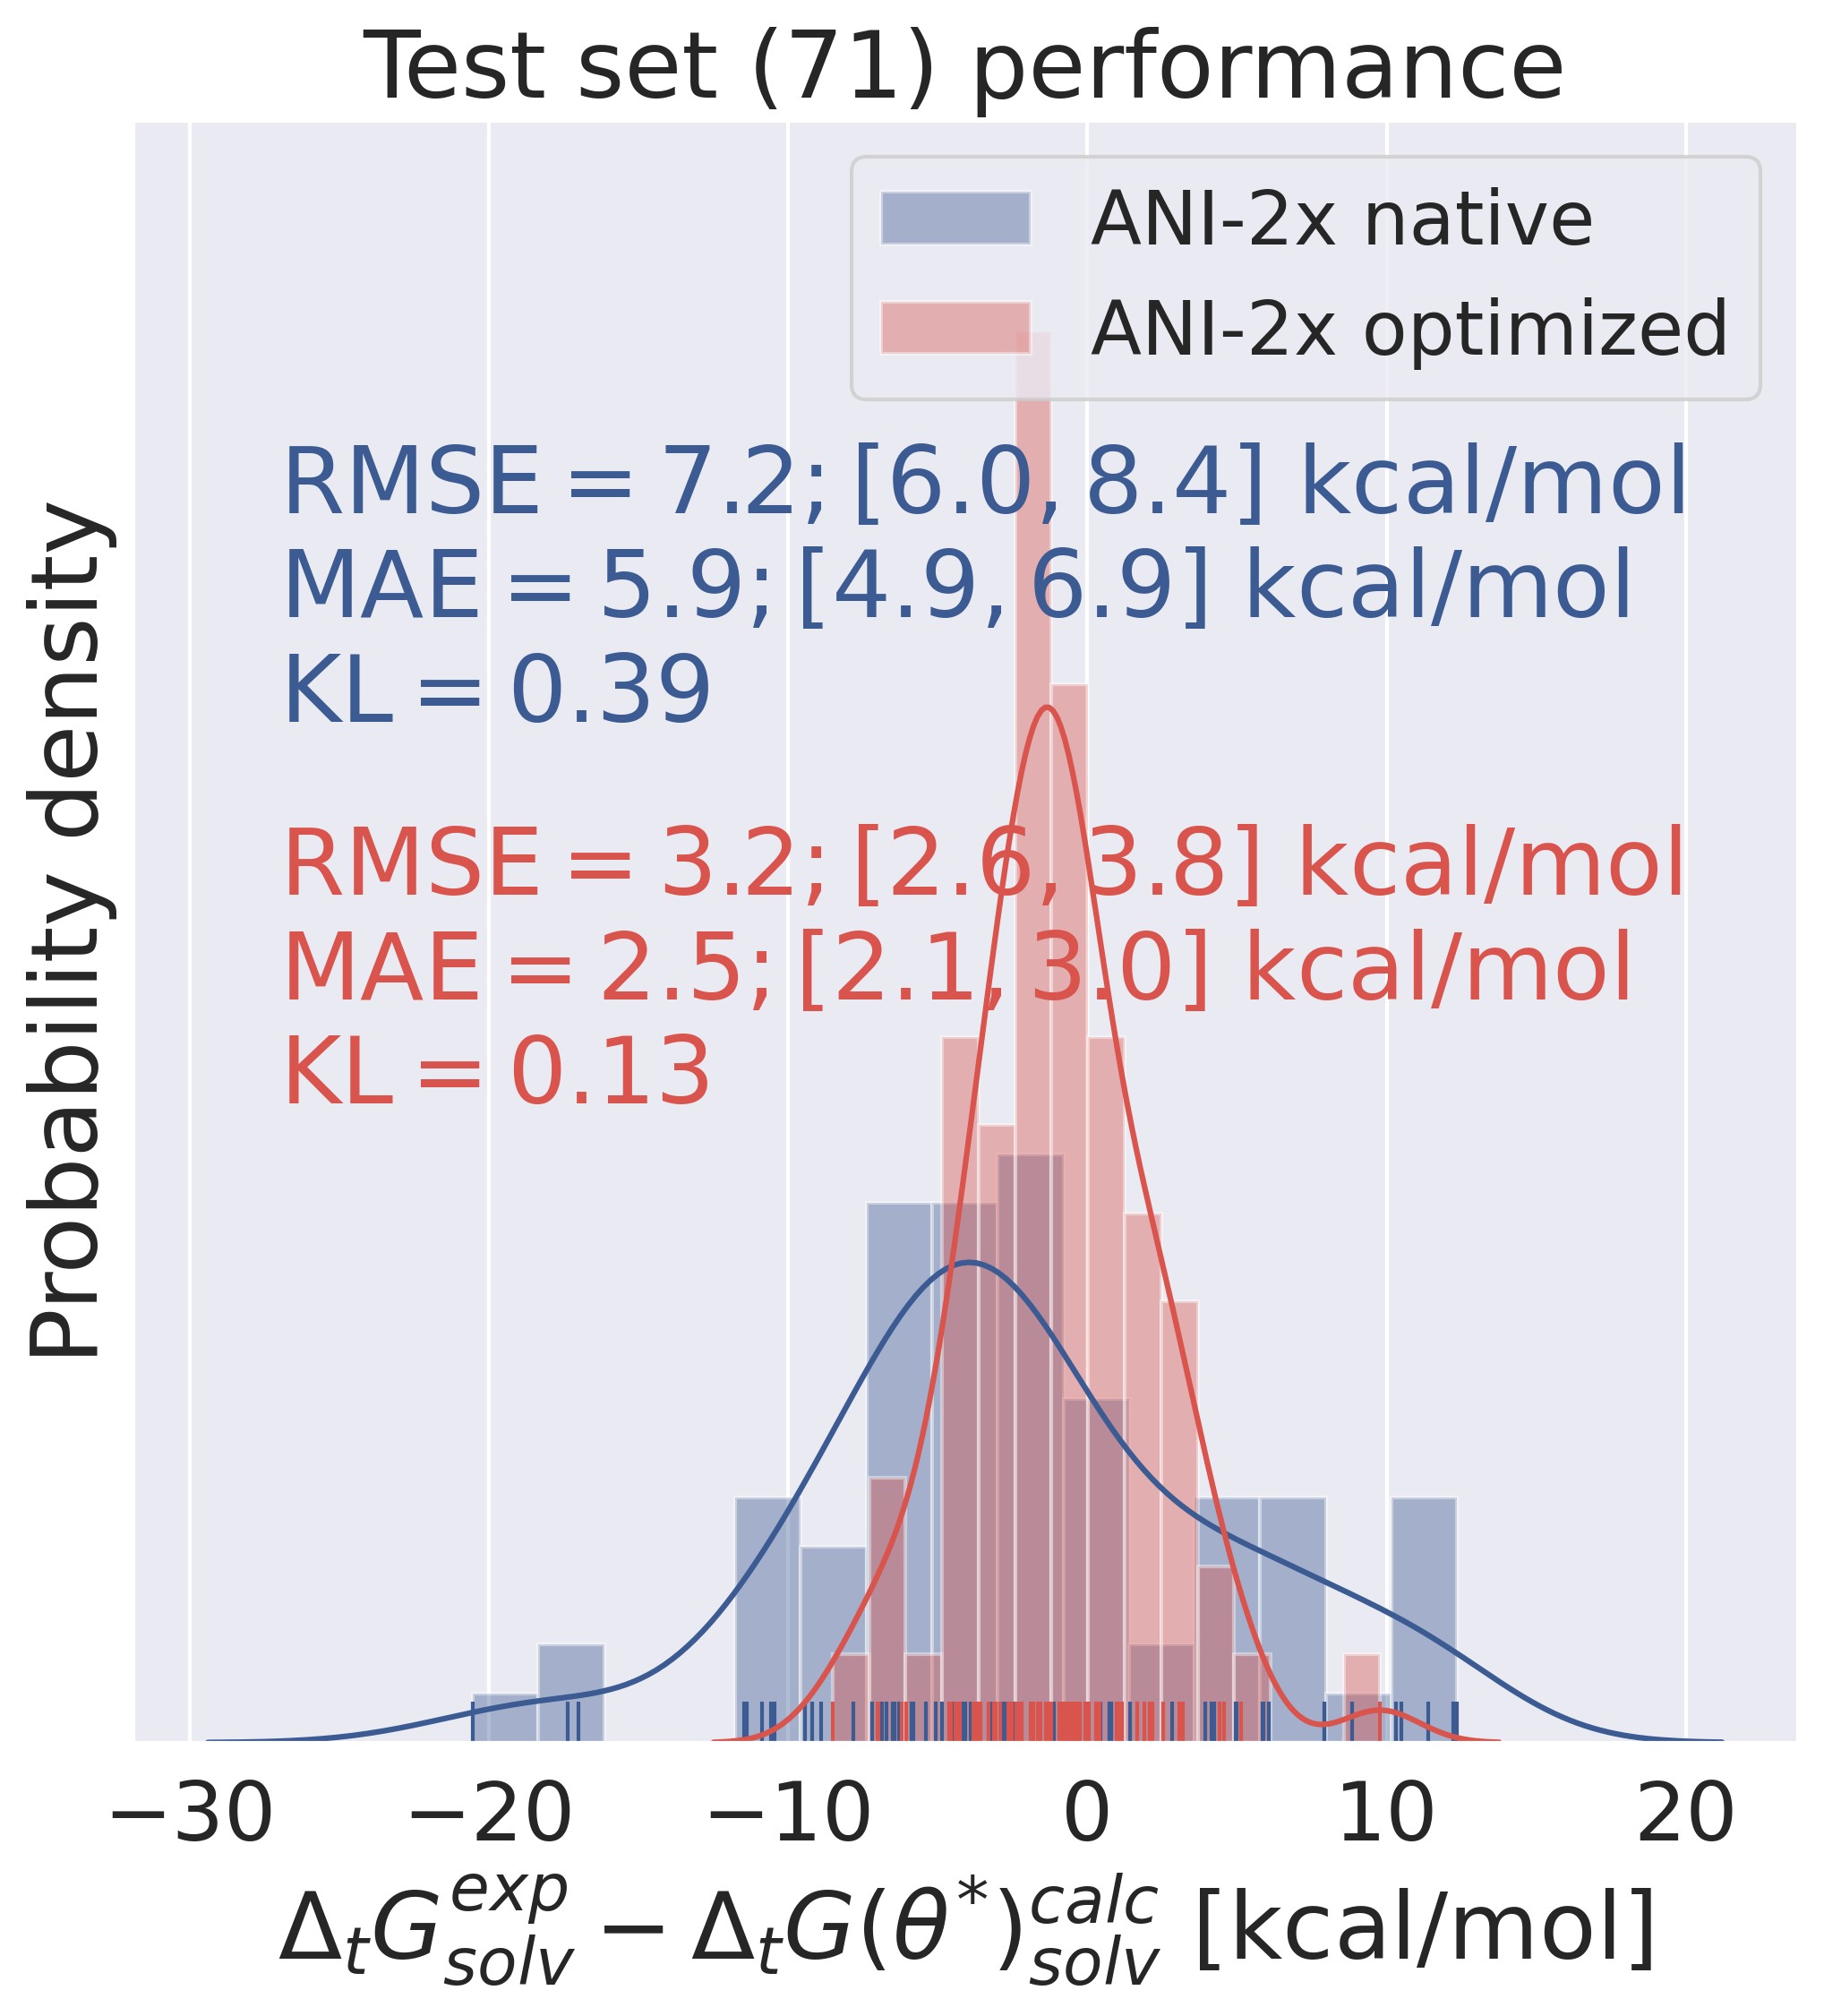

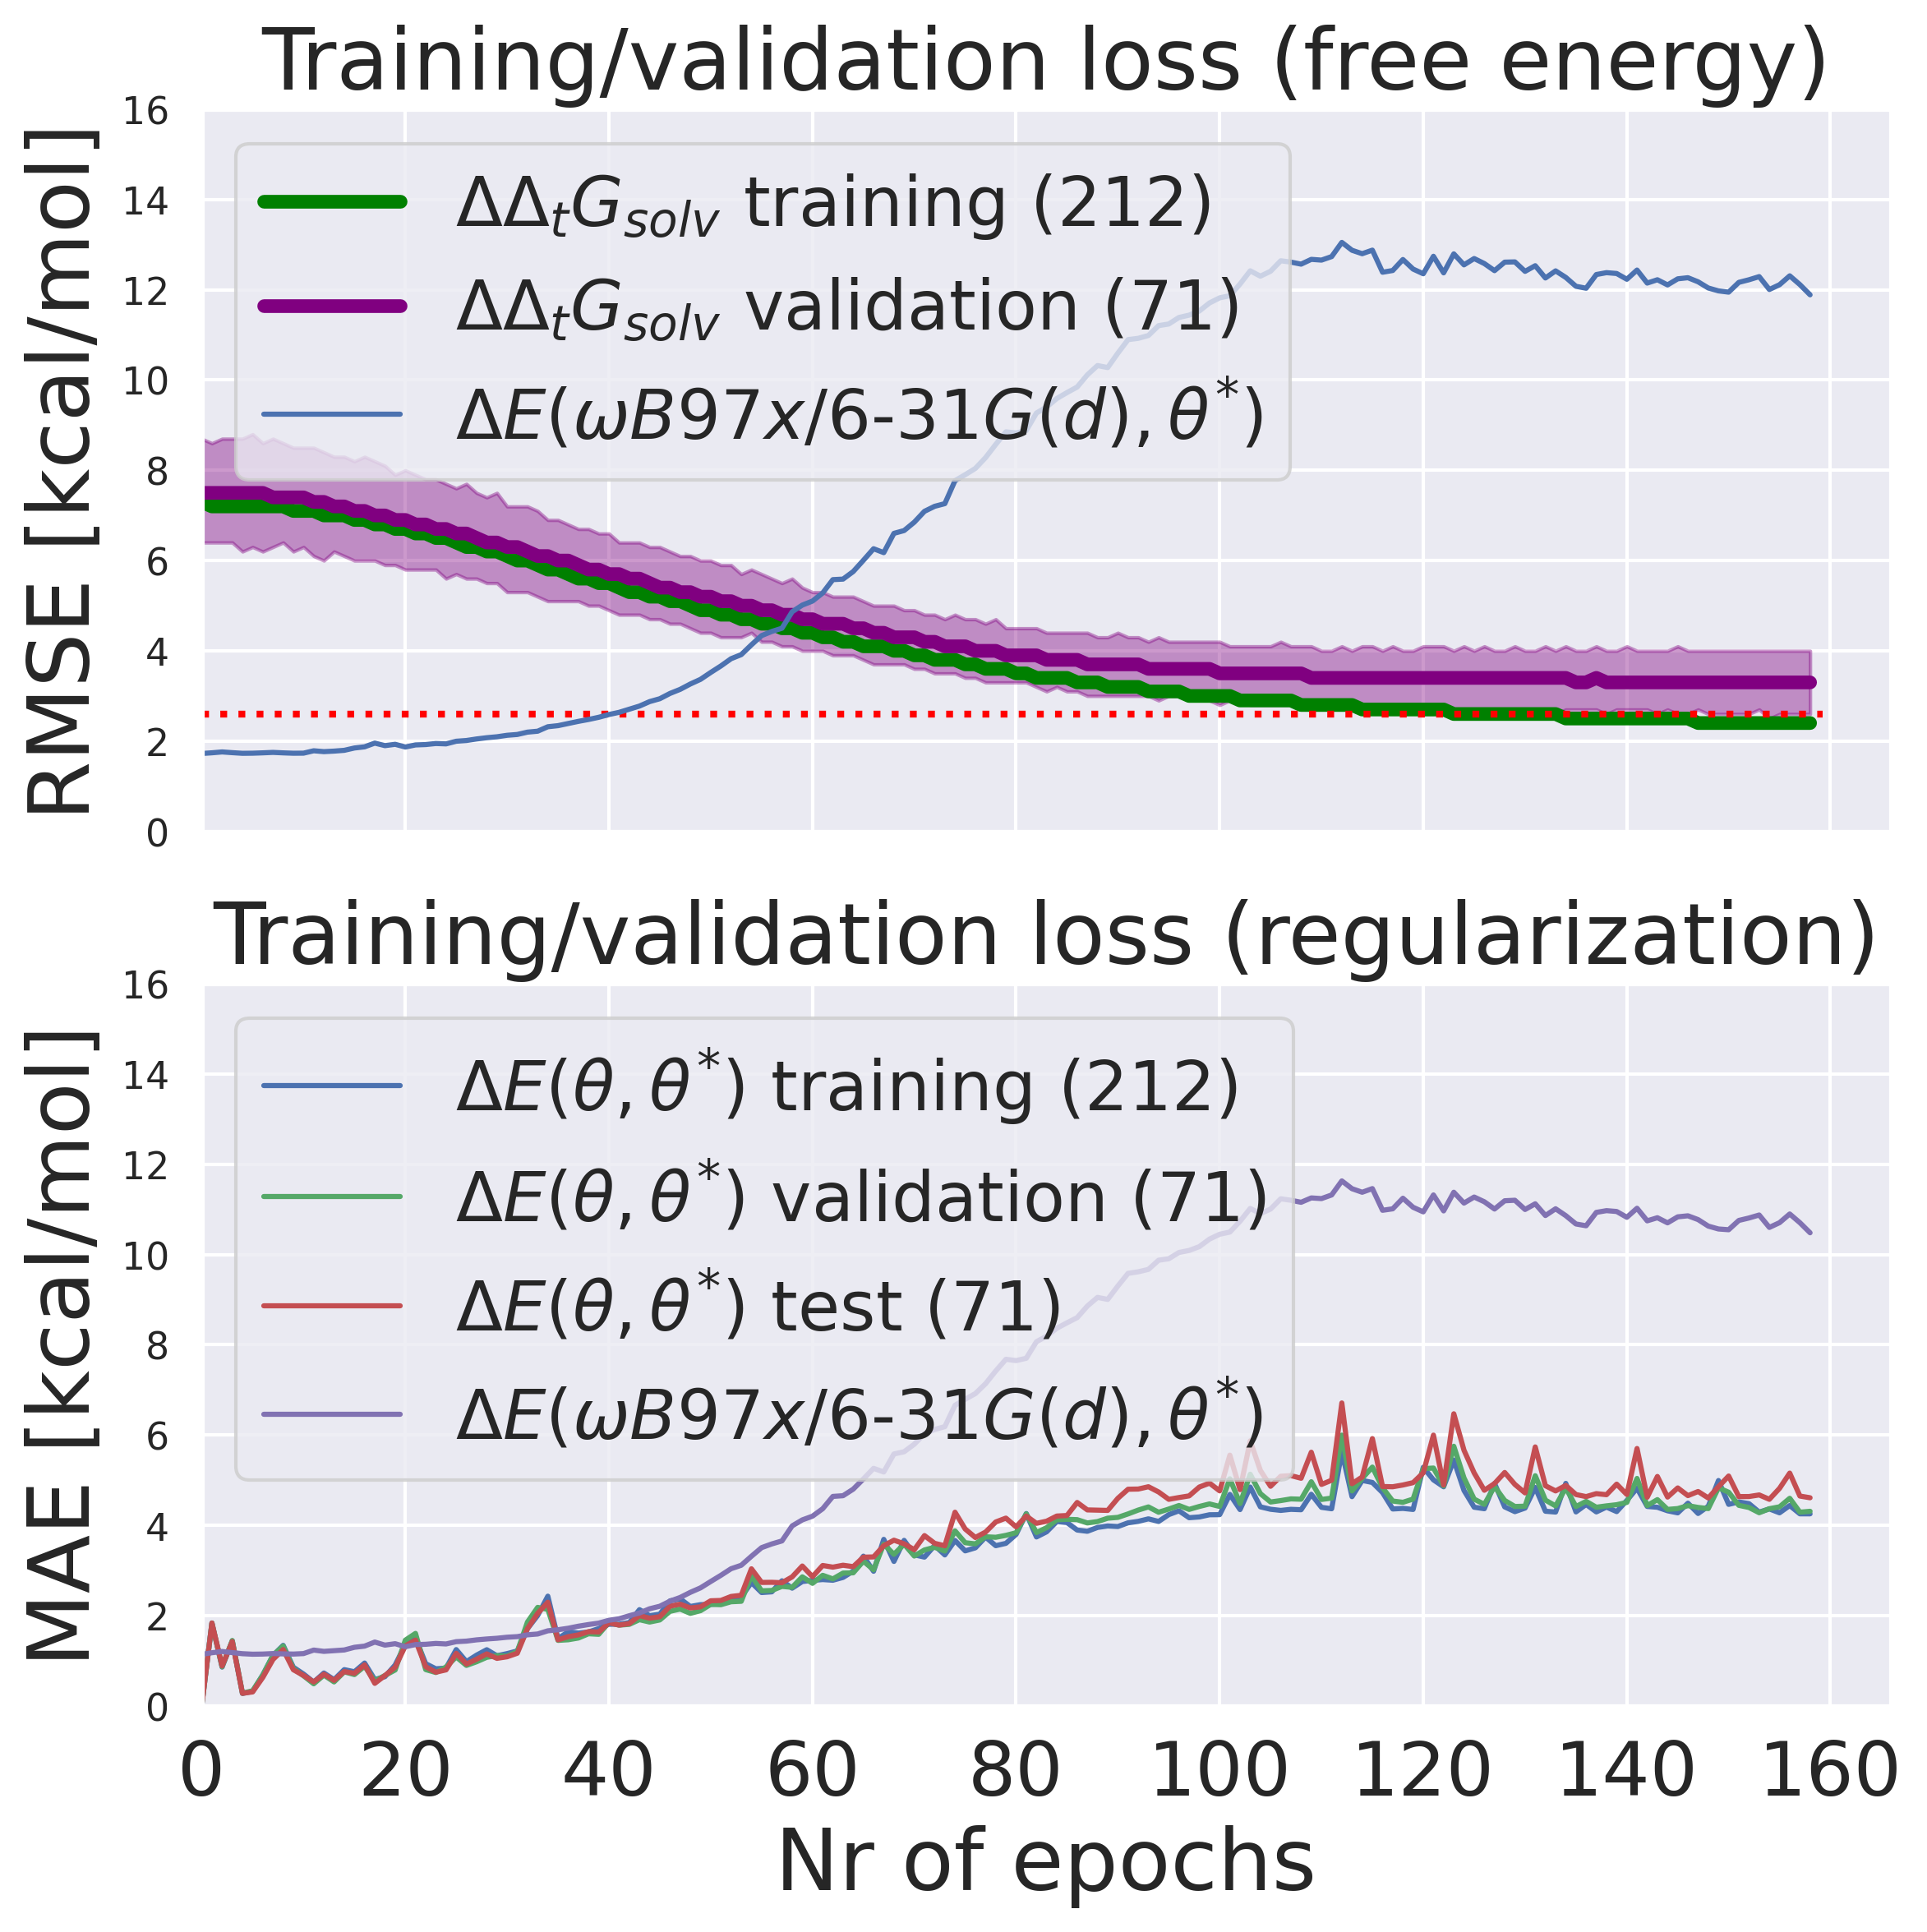

In [3]:
def plot_kde_of_free_energies(exp_, original_, reweighted_):
    # plot the kde of the free energies before and after retraining
    plt.style.use('seaborn-deep')
    from scipy.stats import entropy
    from neutromeratio.analysis import compute_kl_divergence, bootstrap_rmse_r
    sns.set(color_codes=True)
    plt.figure(figsize=[8, 8], dpi=300)
    fontsize = 25
    plt.title('Test set (71) performance', fontsize=fontsize)
    delta_exp_original = np.array(exp_) - np.array(original_)
    kl = compute_kl_divergence(np.array(exp_), np.array(original_))
    rmse, mae, rho = (bootstrap_rmse_r(np.array(exp_), np.array(original_), 1000))
    plt.text(-27.0, 0.12, f'''RMSE$ = {rmse}$ kcal/mol
MAE$ = {mae}$ kcal/mol
KL$ = {kl:.2f}$
''', fontsize=fontsize, color=sns.xkcd_rgb["denim blue"])

    sns.distplot(delta_exp_original, kde=True, rug=True, bins=15, label="ANI-2x native", color=sns.xkcd_rgb["denim blue"])
    delta_exp_reweighted = np.array(exp_) - np.array(reweighted_)
    rmse, mae, rho = (bootstrap_rmse_r(np.array(exp_), np.array(reweighted_), 1000))
    kl = compute_kl_divergence(np.array(exp_), np.array(reweighted_))
    plt.text(-27.0, 0.07, f'''RMSE$ = {rmse}$ kcal/mol
MAE$ = {mae}$ kcal/mol
KL$ = {kl:.2f}$
''', fontsize=fontsize, color=sns.xkcd_rgb["pale red"])

    
    sns.distplot(delta_exp_reweighted, kde=True, rug=True, bins=15, label="ANI-2x optimized", color=sns.xkcd_rgb["pale red"])
    plt.legend(fontsize=fontsize-5)
    plt.ylabel('Probability density', fontsize=fontsize)
    plt.xlabel(r'$\Delta_{t} G_{solv}^{exp} - \Delta_{t} G( \theta^{*})_{solv}^{calc}$ [kcal/mol]', fontsize=fontsize)
    plt.xticks(fontsize= 22)
    plt.yticks(fontsize= 22)

    plt.yticks([])
    plt.show()
    
    
def plot_training_curve(rmse=[],mse=[]):

    sns.set(color_codes=True)
    plt.style.use('seaborn-deep')
    fontsize = 25

    f, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=False, figsize=[8, 8], dpi=300)
    ax1.set_ylabel('RMSE [kcal/mol]', fontsize=fontsize)
    ax2.set_ylabel('MAE [kcal/mol]', fontsize=fontsize)
    #ax3.set_ylabel('MAE [kcal/mol]', fontsize=fontsize)

    ax1.set_title('Training/validation loss (free energy)', fontsize=fontsize)
    ax1.plot([t[0].bootstrap_percentiles(95)[0] for t in training_results_bootstrapped], linewidth=4, label=r'$\Delta\Delta_{t}G_{solv}$ training (212)', color='green')
    ax1.plot([v[0].bootstrap_percentiles(95)[0] for v in validation_results_bootstrapped], linewidth=4, label=r'$\Delta\Delta_{t}G_{solv}$ validation (71)', color='purple')
    lower_bound = [v[0].bootstrap_percentiles(95)[1] for v in validation_results_bootstrapped]
    upper_bound = [v[0].bootstrap_percentiles(95)[2] for v in validation_results_bootstrapped]
    ax1.fill_between(np.linspace(0,len(lower_bound)-1,len(lower_bound)), lower_bound, upper_bound, alpha=0.4, color='purple')
    #plt.axvline(best_performing_epoch,0,14, color='red', linewidth=2, linestyle=':')
    ax1.axhline(2.6,0,0.96, color='red', linewidth=2, linestyle=':')
    ax1.set_ylim(0,16)
    ax1.set_xlim(0,)
    
    ax2.set_title('Training/validation loss (regularization)', fontsize=fontsize)

    ax2.plot(penalty_training_, label=r'$\Delta E(\theta, \theta^{*})$ training (212)')
    ax2.plot(penalty_validation_, label=r'$\Delta E(\theta, \theta^{*})$ validation (71)')
    ax2.plot(penalty_testing_, label=r'$\Delta E(\theta, \theta^{*})$ test (71)')
    if rmse:
        ax1.plot(rmse, label=r'$\Delta E(\omega B97x/6$-$31G(d), \theta^{*})$')
    ax1.legend(fontsize=20)
    if mse:
        ax2.plot(mse, label=r'$\Delta E(\omega B97x/6$-$31G(d), \theta^{*})$')
    ax2.legend(fontsize=20)

    ax2.set_ylim(0,16)

    #plt.yticks(fontsize= 20)
    plt.xticks(fontsize= 22)

    plt.xlabel('Nr of epochs', fontsize=fontsize)
    plt.tight_layout()

plot_kde_of_free_energies(exp_corresponding_to_test_set, test_results[0], test_results[-1])
plot_training_curve(rmse, mae)